In [27]:
# Initialisation
import os
import cv2
import sys
import glob
import time
import threading
import numpy as np
import pandas as pd
import multiprocessing
import matplotlib
import matplotlib.pyplot as plt

ibug_face_tracker_path = 'D:\\hhj\\dlib_and_chehra_stuff' # You'll need to change this
sys.path.append(ibug_face_tracker_path)
import ibug_face_tracker

from data_preparation_helpers import landmark_localiser, landmark_organiser, face_extractor, face_extractor_monitor


data_folder = os.path.realpath(os.path.join(os.getcwd(), '..', 'Manually_Annotated'))
training_labels_path = os.path.realpath(os.path.join(os.getcwd(), '..', 'training.csv'))
validation_labels_path = os.path.realpath(os.path.join(os.getcwd(), '..', 'validation.csv'))
training_labels_pkl = os.path.realpath(os.path.join(os.getcwd(), '..', 'training.pkl'))
validation_labels_pkl = os.path.realpath(os.path.join(os.getcwd(), '..', 'validation.pkl'))
training_data_folder = os.path.realpath(os.path.join(os.getcwd(), '..', 'training'))
validation_data_folder = os.path.realpath(os.path.join(os.getcwd(), '..', 'validation'))
training_data_pkl = os.path.realpath(os.path.join(os.getcwd(), '..', 'training_face_images.pkl'))
validation_data_pkl = os.path.realpath(os.path.join(os.getcwd(), '..', 'validation_face_images.pkl'))

# Get expression names
label_classes = {}
label_classes_path = os.path.join(os.getcwd(), 'expression_classes.csv')
with open(label_classes_path, 'r') as label_classes_file:
    label_classes_file.readline()
    while True:
        line = label_classes_file.readline().replace('\n', '').replace('\r', '')
        if len(line) == 0:
            break
        else:
            fields = line.split(',')
            label_classes[int(fields[0])] = fields[1]

print('All initialised.')

All initialised.


In [125]:
# Load labels
def load_labels(labels_path):
    labels = []
    problematic_lines = []
    line_number = 1
    with open(labels_path, 'r') as labels_file:
        labels_file.readline()
        while True:
            line = labels_file.readline().replace('\n', '').replace('\r', '')
            if len(line) == 0:
                break
            else:
                try:
                    fields = line.split(',')
                    label = {}
                    label['image_path'] = fields[0]
                    label['face_box'] = tuple([int(x) for x in fields[1:5]])
                    label['landmarks'] = np.array([float(x) for x in fields[5].split(';')]).reshape([-1, 2])
                    label['expression'] = int(fields[6])
                    label['valence'] = float(fields[6])
                    label['arousal'] = float(fields[7])
                    labels.append(label)
                except:
                    problematic_lines.append(line_number)
            line_number = line_number + 1
    return pd.DataFrame(labels), problematic_lines


training_labels, problems = load_labels(training_labels_path)
print('Loaded: ' + training_labels_path + ', %d records found.' % training_labels.shape[0])
if len(problems) > 0:
    print('Problematic lines: ' + ','.join([str(x) for x in problems]))
validation_labels, problems = load_labels(validation_labels_path)
print('Loaded: ' + validation_labels_path + ', %d records found.' % validation_labels.shape[0])
if len(problems) > 0:
    print('Problematic lines: ' + ','.join([str(x) for x in problems]))

Loaded: D:\hhj\AffectNet\training.csv, 414799 records found.
Problematic lines: 315314
Loaded: D:\hhj\AffectNet\validation.csv, 5500 records found.


In [44]:
# Check whether all images exists
image_files = set([os.path.realpath(x) for x in glob.glob(os.path.join(data_folder, '*', '*.*'))])
training_images = set([os.path.realpath(os.path.join(data_folder, x)) for x in training_labels['image_path']])
training_problems = training_images.difference(image_files)
if len(training_problems) == 0:
    print('Training labels are fine.')
else:
    print('Some training labels are wrong (image missing), do something...')
validation_images = set([os.path.realpath(os.path.join(data_folder, x)) for x in validation_labels['image_path']])
validation_problems = validation_images.difference(image_files)
if len(validation_problems) == 0:
    print('Validation labels are fine.')
else:
    print('Some validation labels are wrong (image missing), do something...')

Training labels are fine.
Validation labels are fine.


In [230]:
# Localise facial landmarks in the validation images
number_of_workers = 6
job_queue = multiprocessing.Queue()
result_queue = multiprocessing.Queue()
result_list = [None] * validation_labels.shape[0]
organiser = threading.Thread(target=landmark_organiser, args=(result_queue, result_list))
organiser.start()
workers = [multiprocessing.Process(target=landmark_localiser, 
                                   args=(job_queue, result_queue)) 
           for idx in range(number_of_workers)]
for worker in workers:
    worker.start()

# Put the jobs
for idx in range(validation_labels.shape[0]):
    job = dict()
    job['image_path'] = os.path.join(data_folder, validation_labels.iloc[idx]['image_path'])
    job['face_box'] = validation_labels.iloc[idx]['face_box']
    job['index'] = idx
    job_queue.put(job)
job_queue.put(None)

# Wait for things to finish
for worker in workers:
    worker.join()
result_queue.put(None)
organiser.join()
problems = []
for idx, item in enumerate(result_list):
    if item is None:
        problems.insert(0, idx)
if len(problems) > 0:
    for idx in problems:
        del result_list[idx]
    validation_labels.drop(problems, inplace=True)
    validation_labels.reset_index(drop=True, inplace=True)
validation_labels = pd.concat((validation_labels, pd.DataFrame(result_list)), axis=1)
print('All validation images processed.')

4931 of 5500 images processed.
All validation images processed.


In [ ]:
# Localise facial landmarks in the training images
number_of_workers = 6
job_queue = multiprocessing.Queue()
result_queue = multiprocessing.Queue()
result_list = [None] * training_labels.shape[0]
organiser = threading.Thread(target=landmark_organiser, args=(result_queue, result_list))
organiser.start()
workers = [multiprocessing.Process(target=landmark_localiser, 
                                   args=(job_queue, result_queue)) 
           for idx in range(number_of_workers)]
for worker in workers:
    worker.start()

# Put the jobs
for idx in range(training_labels.shape[0]):
    job = dict()
    job['image_path'] = os.path.join(data_folder, training_labels.iloc[idx]['image_path'])
    job['face_box'] = training_labels.iloc[idx]['face_box']
    job['index'] = idx
    job_queue.put(job)
job_queue.put(None)

# Wait for things to finish
for worker in workers:
    worker.join()
result_queue.put(None)
organiser.join()
problems = []
for idx, item in enumerate(result_list):
    if item is None:
        problems.insert(0, idx)
if len(problems) > 0:
    for idx in problems:
        del result_list[idx]
    training_labels.drop(problems, inplace=True)
    training_labels.reset_index(drop=True, inplace=True)
training_labels = pd.concat((training_labels, pd.DataFrame(result_list)), axis=1)
print('All training images processed.')

In [231]:
# Pickle the labels
training_labels.to_pickle(training_labels_pkl)
print('Pickled: ' + training_labels_pkl)
validation_labels.to_pickle(validation_labels_pkl)
print('Pickled: ' + validation_labels_pkl)

Pickled: D:\hhj\AffectNet\training.pkl
Pickled: D:\hhj\AffectNet\validation.pkl


In [2]:
# Load the pickled data
training_labels = pd.read_pickle(training_labels_pkl)
print('Loaded: ' + training_labels_pkl)
validation_labels = pd.read_pickle(validation_labels_pkl)
print('Loaded: ' + validation_labels_pkl)

Loaded: D:\hhj\AffectNet\training.pkl
Loaded: D:\hhj\AffectNet\validation.pkl


In [3]:
# See the number of samples per expression class
all_expressions = set(training_labels['expression'].unique().tolist() + validation_labels['expression'].unique().tolist())
for expression in all_expressions:
    print('Expression %d: %d examples.' % (expression, len(training_labels.loc[training_labels['expression'] == expression]) + 
        len(validation_labels.loc[validation_labels['expression'] == expression])))

Expression 0: 75374 examples.
Expression 1: 134915 examples.
Expression 2: 25959 examples.
Expression 3: 14590 examples.
Expression 4: 6878 examples.
Expression 5: 4303 examples.
Expression 6: 25382 examples.
Expression 7: 4250 examples.
Expression 8: 33588 examples.
Expression 9: 12145 examples.
Expression 10: 82914 examples.


In [4]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

neutral


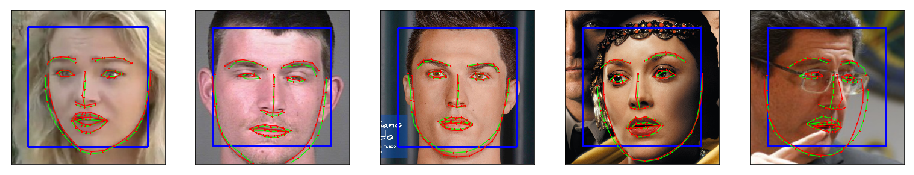

happy


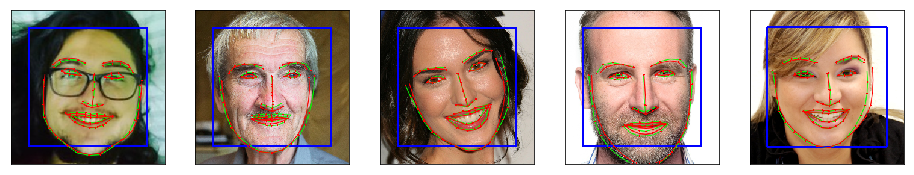

sad


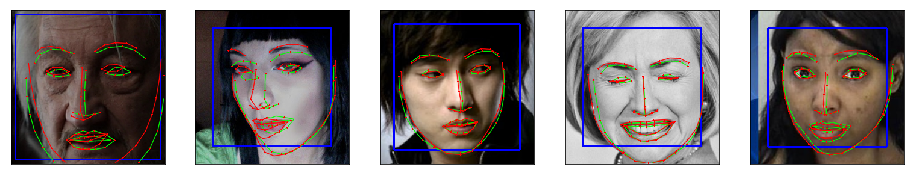

surprise


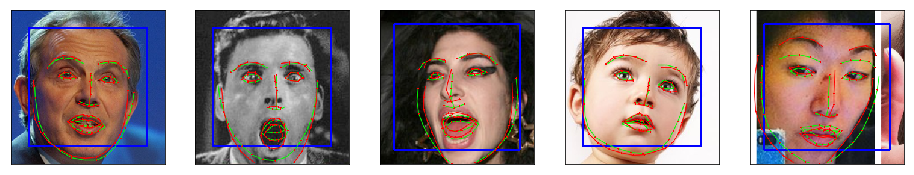

fear


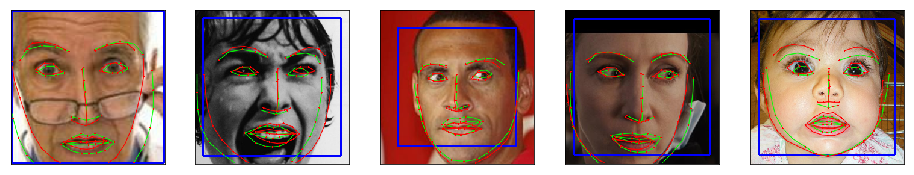

disgust


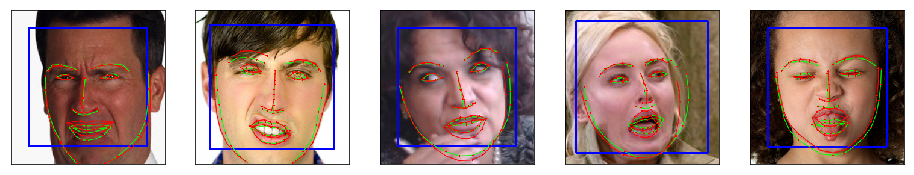

anger


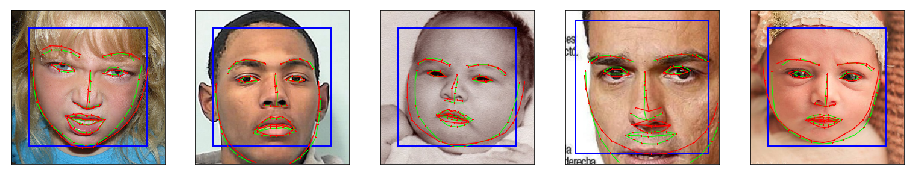

contempt


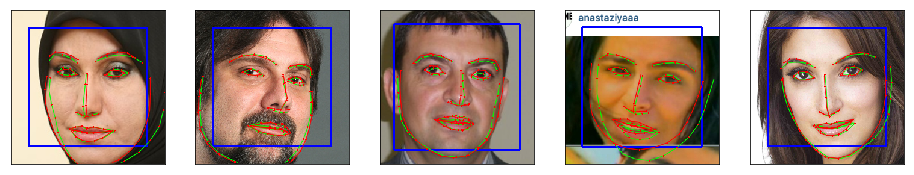

none


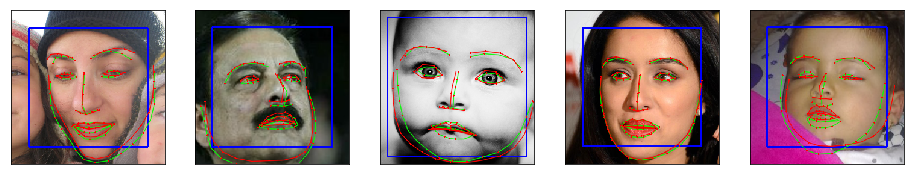

uncertain


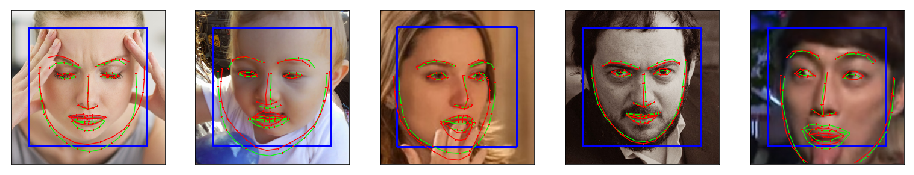

non-face


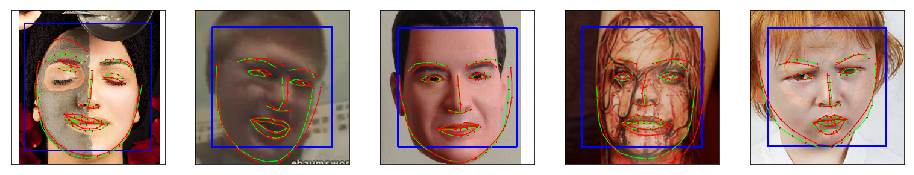

In [5]:
# Show some images in the training set
%matplotlib inline

# Get 5 random samples from each category and render everything
matplotlib.rcParams['figure.figsize'] = [16, 4]
for label_idx, expression in enumerate(all_expressions):
    samples = training_labels.loc[training_labels['expression'] == expression].sample(5)
    for idx in range(len(samples)):
        image_path = os.path.realpath(os.path.join(data_folder, samples.iloc[idx]['image_path']))
        landmarks = samples.iloc[idx]['landmarks']
        ibug_landmarks = samples.iloc[idx]['ibug_facial_landmarks']
        face_box = samples.iloc[idx]['face_box']
        image = cv2.imread(image_path)
        image_dimension = max(image.shape[0], image.shape[1])
        scale = 256.0 / image_dimension
        image = cv2.resize(image, (int(scale * image.shape[1]), int(scale * image.shape[0])))
        landmarks = landmarks * scale
        ibug_landmarks = ibug_landmarks * scale
        top_left = (int(face_box[0] * scale), int(face_box[1] * scale))
        bottom_right = (int((face_box[0] + face_box[2]) * scale), int((face_box[1] + face_box[3]) * scale))
        cv2.rectangle(image, top_left, bottom_right, (255, 0, 0), 2)
        ibug_face_tracker.FaceTracker.plot_landmark_connections(image, landmarks)
        ibug_face_tracker.FaceTracker.plot_facial_landmarks(image, landmarks)
        ibug_face_tracker.FaceTracker.plot_landmark_connections(image, ibug_landmarks, colour=(0, 0, 255))
        ibug_face_tracker.FaceTracker.plot_facial_landmarks(image, ibug_landmarks)
        ax = plt.subplot(1, len(samples), idx + 1)
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_RGB2BGR))
        ax.set_xticks([])
        ax.set_yticks([])
    print(label_classes[label_idx])
    plt.show()

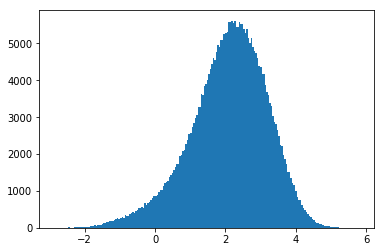

mean: 2.088000, std: 1.092669, min: -2.858019, max: 5.798268


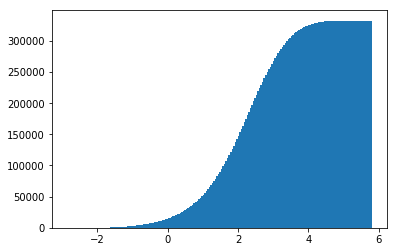

In [6]:
# Let's see the fitting score disttribution (excluding non-face)
%matplotlib inline
fitting_scores = np.array(training_labels[training_labels['expression'] <= 9]['ibug_fitting_scores'].values.tolist())
plt.hist(fitting_scores[:, 0], bins=200)
plt.show()
print('mean: %f, std: %f, min: %f, max: %f' % (fitting_scores[:, 0].mean(), fitting_scores[:, 0].std(), 
                                               fitting_scores[:, 0].min(), fitting_scores[:, 0].max()))
plt.hist(fitting_scores[:, 0], bins=200, cumulative=True)
plt.show()

-1.500000 <= fitting_score < -1.000000


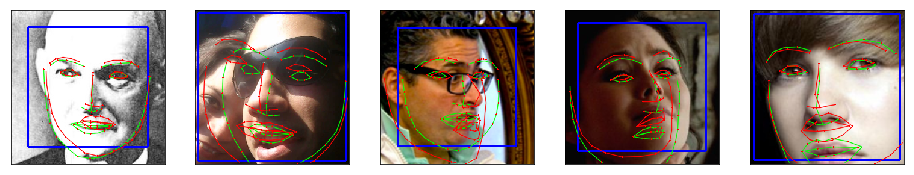

-1.000000 <= fitting_score < -0.500000


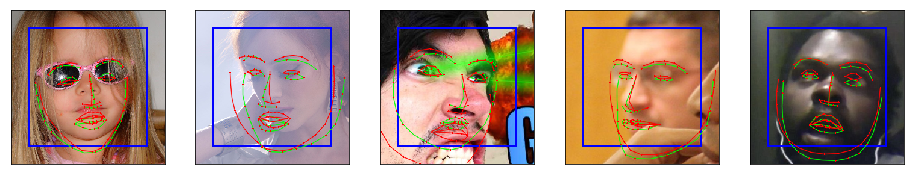

-0.500000 <= fitting_score < 0.000000


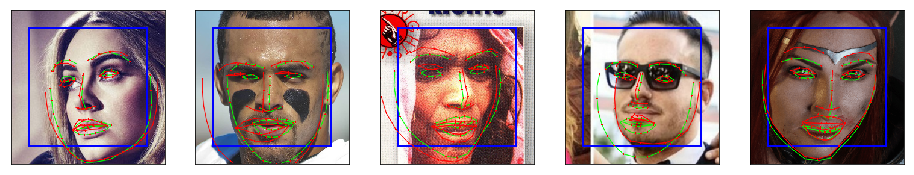

0.000000 <= fitting_score < 0.500000


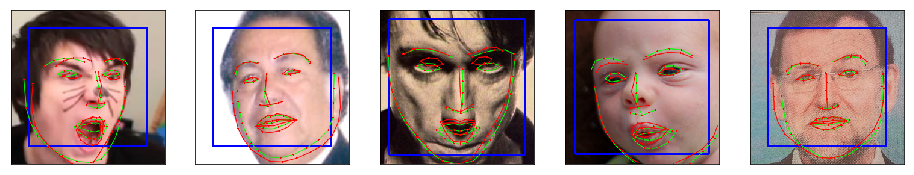

0.500000 <= fitting_score < 1.000000


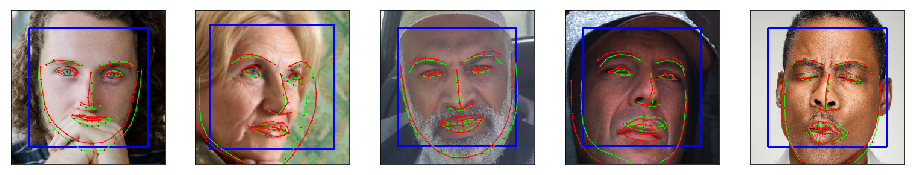

1.000000 <= fitting_score < 1.500000


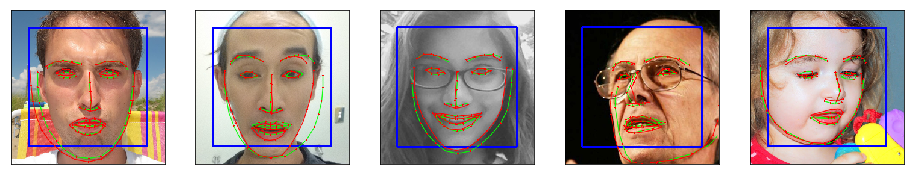

1.500000 <= fitting_score < 2.000000


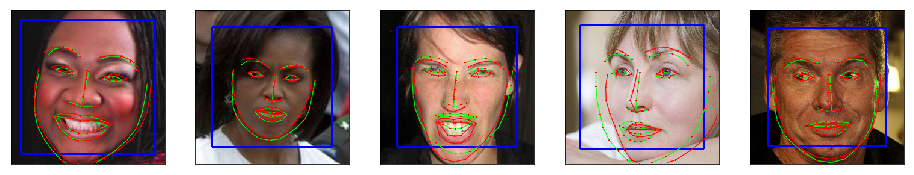

2.000000 <= fitting_score < 2.500000


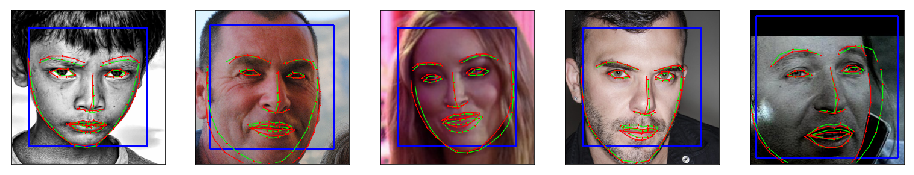

2.500000 <= fitting_score < 3.000000


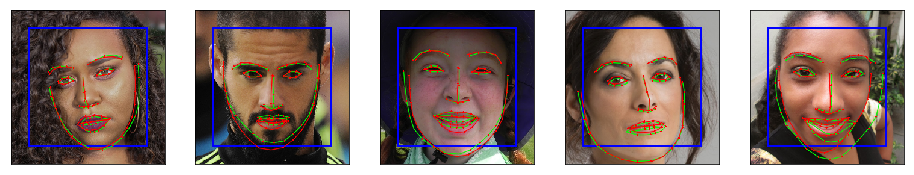

3.000000 <= fitting_score < 3.500000


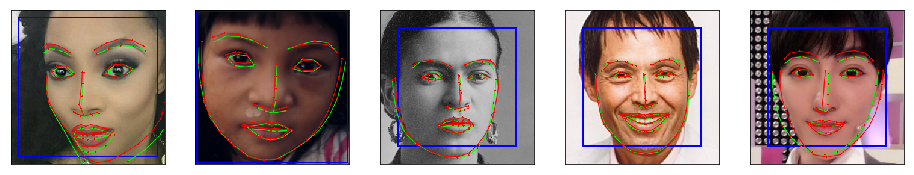

3.500000 <= fitting_score < 4.000000


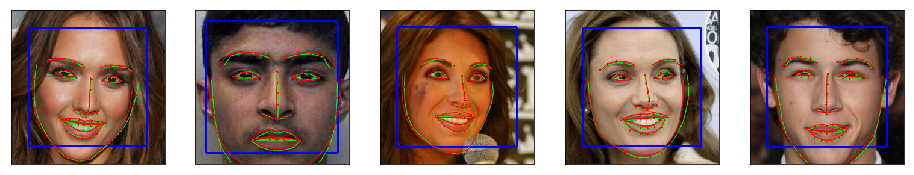

4.000000 <= fitting_score < 4.500000


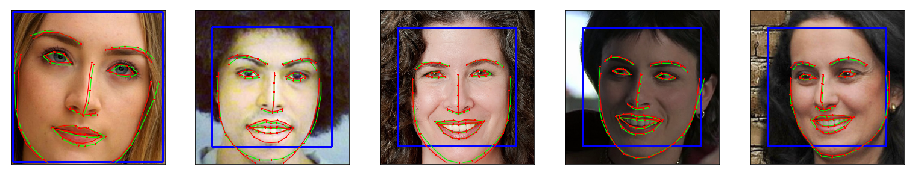

In [7]:
# Plot some face from the distribution
%matplotlib inline

# Show 60 random samples (-1.5 <= fitting_score < 4.5)
matplotlib.rcParams['figure.figsize'] = [16, 4]
fitting_scores = np.array(training_labels['ibug_fitting_scores'].values.tolist())
for row in range(12):
    print('%f <= fitting_score < %f' % (row * 0.5 - 1.5, row * 0.5 - 1.0))
    for col in range(5):
        idx = row * 5 + col
        min_score = idx * 0.1 - 1.5
        max_score = min_score + 0.1
        indices = np.where(np.logical_and(fitting_scores[:, 0] >= min_score, fitting_scores[:, 0] < max_score))[0]
        training_slice = training_labels.iloc[indices]
        sample = training_slice[training_slice['expression'] <= 9].sample(1).iloc[0]
        image_path = os.path.realpath(os.path.join(data_folder, sample['image_path']))
        landmarks = sample['landmarks']
        ibug_landmarks = sample['ibug_facial_landmarks']
        face_box = sample['face_box']
        image = cv2.imread(image_path)
        image_dimension = max(image.shape[0], image.shape[1])
        scale = 256.0 / image_dimension
        image = cv2.resize(image, (int(scale * image.shape[1]), int(scale * image.shape[0])))
        landmarks = landmarks * scale
        ibug_landmarks = ibug_landmarks * scale
        top_left = (int(face_box[0] * scale), int(face_box[1] * scale))
        bottom_right = (int((face_box[0] + face_box[2]) * scale), int((face_box[1] + face_box[3]) * scale))
        cv2.rectangle(image, top_left, bottom_right, (255, 0, 0), 2)
        ibug_face_tracker.FaceTracker.plot_landmark_connections(image, landmarks)
        ibug_face_tracker.FaceTracker.plot_facial_landmarks(image, landmarks)
        ibug_face_tracker.FaceTracker.plot_landmark_connections(image, ibug_landmarks, colour=(0, 0, 255))
        ibug_face_tracker.FaceTracker.plot_facial_landmarks(image, ibug_landmarks)
        ax = plt.subplot(1, 5, col + 1)
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_RGB2BGR))
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show()

In [8]:
# See the number of samples per expression class, when fitting_score is above a threshold
threshold = 0.0
training_fitting_scores = np.array(training_labels['ibug_fitting_scores'].values.tolist())
validation_fitting_scores = np.array(validation_labels['ibug_fitting_scores'].values.tolist())
all_expressions = set(training_labels['expression'].unique().tolist() + validation_labels['expression'].unique().tolist())
for expression in all_expressions:
    training_slice = training_labels.iloc[np.where(training_fitting_scores[:, 0] >= threshold)[0]]
    validation_slice = validation_labels.iloc[np.where(validation_fitting_scores[:, 0] >= threshold)[0]]
    print('Expression %d: %d examples.' % (expression, len(training_slice.loc[training_slice['expression'] == expression]) + 
        len(validation_slice.loc[validation_slice['expression'] == expression])))

Expression 0: 71805 examples.
Expression 1: 131131 examples.
Expression 2: 24265 examples.
Expression 3: 13814 examples.
Expression 4: 6354 examples.
Expression 5: 4098 examples.
Expression 6: 23717 examples.
Expression 7: 4142 examples.
Expression 8: 32065 examples.
Expression 9: 11163 examples.
Expression 10: 65828 examples.


In [4]:
# Extract face images
fitting_score_threshold = 0.0
target_size = (60, 60)
margin = (0.1, 0.1, 0.1, 0.1)
number_of_workers = 6

# Start the workers
job_queue = multiprocessing.Queue()
output_queue = multiprocessing.Queue()
monitor = threading.Thread(target=face_extractor_monitor, args=(output_queue,))
monitor.start()
workers = [multiprocessing.Process(target=face_extractor, args=(job_queue, output_queue, target_size, margin)) 
           for idx in range(number_of_workers)]
for worker in workers:
    worker.start()

# Create the jobs
for label in label_classes:
    training_class_folder = os.path.join(training_data_folder, label_classes[label])
    if not os.path.exists(training_class_folder):
        os.makedirs(training_class_folder)
    for _, row in training_labels[training_labels['expression'] == label].iterrows():
        if row['ibug_fitting_scores'][0] >= fitting_score_threshold:
            image_path = os.path.join(data_folder, row['image_path'])
            landmarks = row['ibug_facial_landmarks']
            output_path = os.path.join(training_class_folder, 
                                       row['image_path'].replace('\\', '__').replace('/', '__'))
            output_path = os.path.splitext(output_path)[0] + '.png'
            job_queue.put({'image_path': image_path, 'landmarks': landmarks, 'output_path': output_path})
    validation_class_folder = os.path.join(validation_data_folder, label_classes[label])
    if not os.path.exists(validation_class_folder):
        os.makedirs(validation_class_folder)
    for _, row in validation_labels[validation_labels['expression'] == label].iterrows():
        if row['ibug_fitting_scores'][0] >= fitting_score_threshold:
            image_path = os.path.join(data_folder, row['image_path'])
            landmarks = row['ibug_facial_landmarks']
            output_path = os.path.join(validation_class_folder, 
                                       row['image_path'].replace('\\', '__').replace('/', '__'))
            output_path = os.path.splitext(output_path)[0] + '.png'
            job_queue.put({'image_path': image_path, 'landmarks': landmarks, 'output_path': output_path})
job_queue.put(None)

# Wait for things to finish
for worker in workers:
    worker.join()
output_queue.put(None)
monitor.join()
print('All face images extracted.')

2099 face images extracted.
3972 face images extracted.
5878 face images extracted.
7662 face images extracted.
9477 face images extracted.
11253 face images extracted.
13087 face images extracted.
14917 face images extracted.
16713 face images extracted.
18465 face images extracted.
20304 face images extracted.
22098 face images extracted.
24045 face images extracted.
26063 face images extracted.
28090 face images extracted.
29922 face images extracted.
31987 face images extracted.
34156 face images extracted.
36215 face images extracted.
38283 face images extracted.
40323 face images extracted.
42401 face images extracted.
44336 face images extracted.
46243 face images extracted.
48244 face images extracted.
49918 face images extracted.
51820 face images extracted.
53206 face images extracted.
54918 face images extracted.
56709 face images extracted.
58884 face images extracted.
60443 face images extracted.
62067 face images extracted.
63670 face images extracted.
65506 face images e

In [28]:
# Transfrom the validation images into panda data frame
validation_data = []
last_check_time = time.time()
for label in label_classes:
    class_folder = os.path.join(validation_data_folder, label_classes[label])
    image_files = glob.glob(os.path.join(class_folder, '*.png'))
    for image_file in image_files:
        face_image = cv2.cvtColor(cv2.imread(image_file), cv2.COLOR_BGR2GRAY)
        image_path = os.path.splitext(os.path.basename(image_file).replace('__', '/'))[0] + '.jpg'
        sample = {'expression': label, 'face_image': face_image, 'image_path': image_path}
        validation_data.append(sample)
        current_time = time.time()
        if current_time - last_check_time > 30.0:
            print('%d images loaded.' % len(validation_data))
            last_check_time = current_time
validation_data = pd.DataFrame(validation_data)
validation_data.to_pickle(validation_data_pkl)
print('Pickled: ' + validation_data_pkl)

Pickled: D:\hhj\AffectNet\validation_face_images.pkl


In [32]:
# Transfrom the training images into panda data frame
training_data = []
last_check_time = time.time()
for label in label_classes:
    class_folder = os.path.join(training_data_folder, label_classes[label])
    image_files = glob.glob(os.path.join(class_folder, '*.png'))
    for image_file in image_files:
        face_image = cv2.cvtColor(cv2.imread(image_file), cv2.COLOR_BGR2GRAY)
        image_path = os.path.splitext(os.path.basename(image_file).replace('__', '/'))[0] + '.jpg'
        sample = {'expression': label, 'face_image': face_image, 'image_path': image_path}
        training_data.append(sample)
        current_time = time.time()
        if current_time - last_check_time > 30.0:
            print('%d images loaded.' % len(training_data))
            last_check_time = current_time
training_data = pd.DataFrame(training_data)
training_data.to_pickle(training_data_pkl)
print('Pickled: ' + training_data_pkl)

56070 images loaded.
69786 images loaded.
82842 images loaded.
96689 images loaded.
110107 images loaded.
122215 images loaded.
135145 images loaded.
148976 images loaded.
163362 images loaded.
177850 images loaded.
190563 images loaded.
203868 images loaded.
217733 images loaded.
231536 images loaded.
244926 images loaded.
258061 images loaded.
271403 images loaded.
284845 images loaded.
298230 images loaded.
311430 images loaded.
324587 images loaded.
337965 images loaded.
351115 images loaded.
364501 images loaded.
378045 images loaded.
Pickled: D:\hhj\AffectNet\training_face_images.pkl


neutral


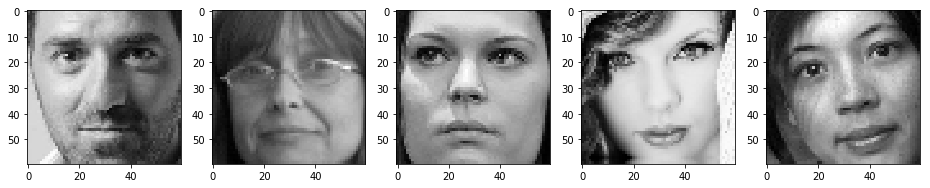

happy


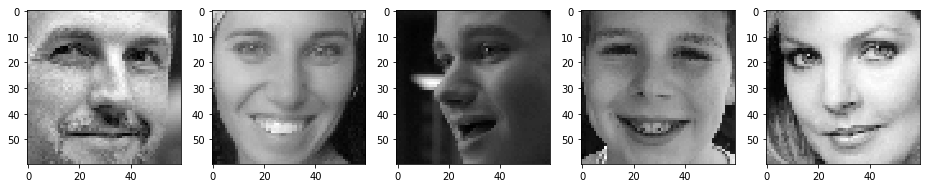

sad


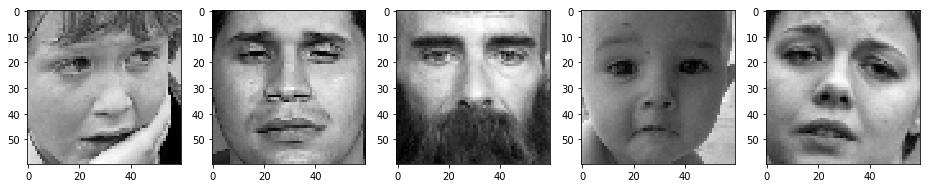

surprise


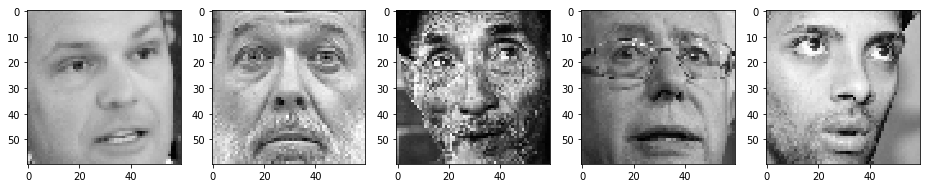

fear


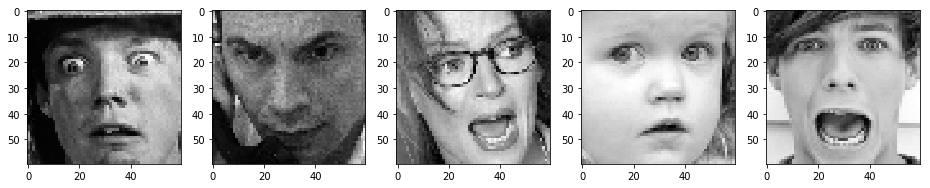

disgust


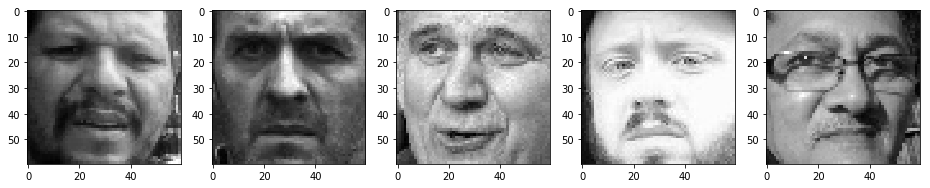

anger


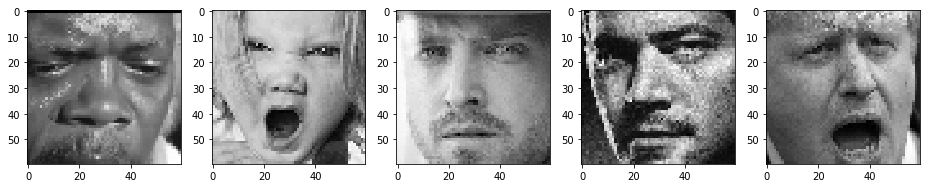

contempt


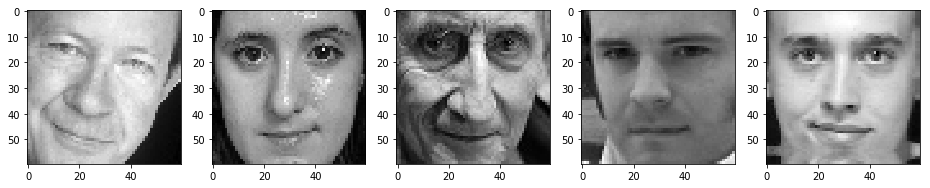

none


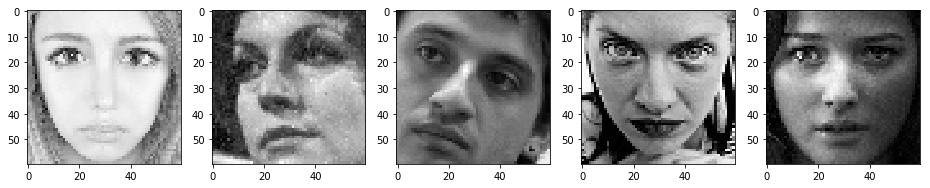

uncertain


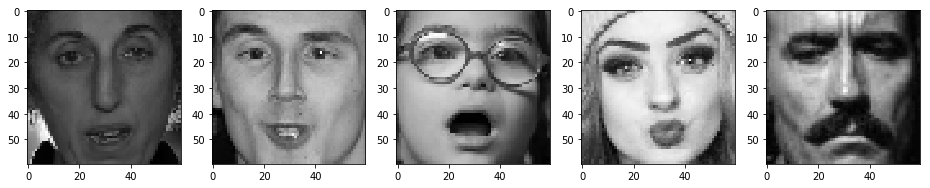

non-face


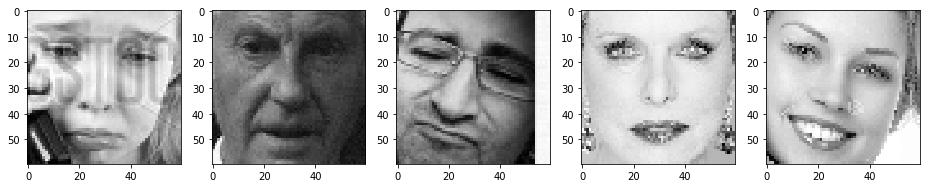

In [42]:
# As an example, let's load from the pickled training data and show some images
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = [16, 4]
training_data = pd.read_pickle(training_data_pkl)
for expression in label_classes:
    print(label_classes[expression])
    samples = training_data[training_data['expression'] == expression].sample(5)
    idx = 1
    for _, sample in samples.iterrows():
        plt.subplot(1, samples.shape[0], idx)
        plt.imshow(sample['face_image'], cmap='gray')
        idx += 1
    plt.show()